In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [20]:
df = process_folder(path_to_data, path_to_output, files=[20,17,14,11,8,5,2], plot=False, labels=True,)

Binlog data extracted
Processing run: 2024-11-08T161448
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 240, 'bin_file': '2024-11-08T161448.bin'}
836458000 datapoints extracted
LABELS: 640 bubble labels with VeloOut != -1 extracted.

Missing Labels:
L_idx: L253, ExitIdx: 327054128, VeloOut: 1.92765
L_idx: L384, ExitIdx: 490162316, VeloOut: 2.32511
EXTRACTED: 638 bubbles have VeloOut != -1 out of 3502 total bubbles.
            bubble_idx E_idx L_idx  VeloOut  \
0  0_2024-11-08T161448    E0    -1 -1.00000   
1  1_2024-11-08T161448    E1    -1 -1.00000   
2  2_2024-11-08T161448    E2    L0  1.46359   
3  3_2024-11-08T161448    E3    -1 -1.00000   
4  4_2024-11-08T161448    E4    -1 -1.00000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5772881507873535, 0.5646534562110901, 0.546...       240  2.083333e+07  
1  [0.6290475130081177, 0.6247749328613281, 0.629...       240  2.08333

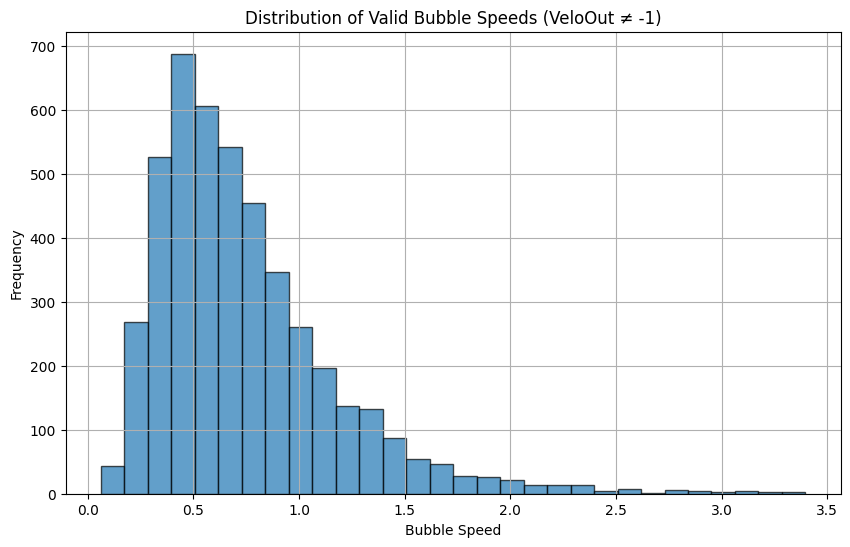

In [21]:
# Filter out invalid speeds
valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [22]:
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = save_second_scaler(df)

In [23]:
# with open(path_to_output+'/scalers/feature_scaler2-20%3.pkl', 'wb') as f:
#     pickle.dump(feature_scaler, f)

# with open(path_to_output+'/scalers/target_scaler2-20%3.pkl', 'wb') as f:
#     pickle.dump(target_scaler, f)

-1.0


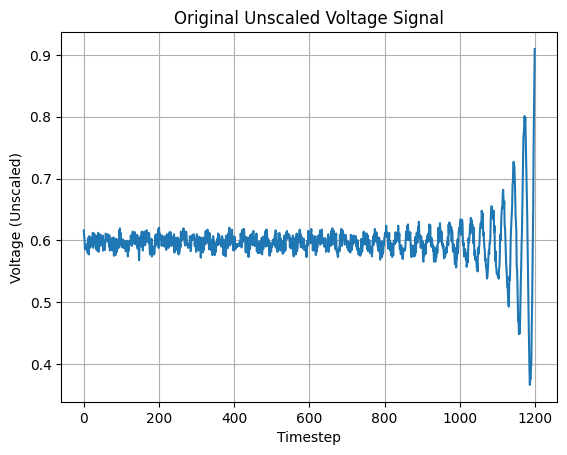

In [24]:
# Select a specific bubble by index (e.g., index 1)
i=137
voltage_signal = df["VoltageOut"].iloc[i]  # This is unscaled
print(df['VeloOut'].iloc[i])
# Create x-axis based on signal length
x = np.arange(len(voltage_signal))

# Plot
plt.plot(x, voltage_signal)
plt.title("Original Unscaled Voltage Signal")
plt.xlabel("Timestep")
plt.ylabel("Voltage (Unscaled)")
plt.grid(True)
plt.show()

In [25]:
chance = 0.3
bins = 30
X_train_scaled, y_train_scaled = random_noise(X_train_scaled, y_train_scaled, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train_scaled, bins)
factors = calculate_duplication_factors(hist)
#X_train_scaled, y_train_scaled = duplicate_and_augment_data(X_train_scaled, y_train_scaled, bin_indices, factors, noise=0.005)
X_train_scaled, y_train_scaled = flatten_data_distribution(X_train_scaled, y_train_scaled, bins, scaling_factor=0.05, noise=0.005)

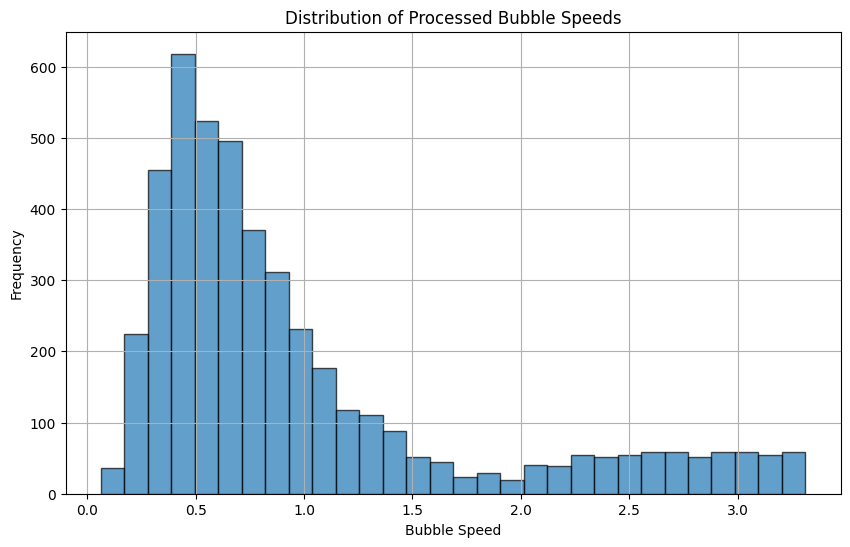

In [26]:
y_train_fig = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten() 
plt.figure(figsize=(10, 6))
plt.hist(y_train_fig, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Processed Bubble Speeds")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [27]:
X_train_scaled.shape

(4565, 1200)

In [28]:
X_train_tensor = torch.tensor(X_train_scaled[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled[..., np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Epoch 1/15000 - Train Loss: 3.8663 - Val Loss: 1.1368
Epoch 100/15000 - Train Loss: 0.8572 - Val Loss: 0.5132
Epoch 200/15000 - Train Loss: 0.3515 - Val Loss: 0.2353
Epoch 300/15000 - Train Loss: 0.1104 - Val Loss: 0.1122
Epoch 400/15000 - Train Loss: 0.0861 - Val Loss: 0.1043
Epoch 500/15000 - Train Loss: 0.0683 - Val Loss: 0.0858
Epoch 600/15000 - Train Loss: 0.0568 - Val Loss: 0.0470
Epoch 700/15000 - Train Loss: 0.0652 - Val Loss: 0.0399
Epoch 800/15000 - Train Loss: 0.0583 - Val Loss: 0.0369
Epoch 900/15000 - Train Loss: 0.0529 - Val Loss: 0.0308
Epoch 1000/15000 - Train Loss: 0.0479 - Val Loss: 0.0247
Epoch 1100/15000 - Train Loss: 0.0436 - Val Loss: 0.0211
Epoch 1200/15000 - Train Loss: 0.0394 - Val Loss: 0.0185
Epoch 1300/15000 - Train Loss: 0.0361 - Val Loss: 0.0161
Epoch 1400/15000 - Train Loss: 0.0333 - Val Loss: 0.0141
Epoch 1500/15000 - Train Loss: 0.0306 - Val Loss: 0.0125
Epoch 1600/15000 - Train Loss: 0.1004 - Val Loss: 0.0502
Epoch 1700/15000 - Train Loss: 0.0254 - Val

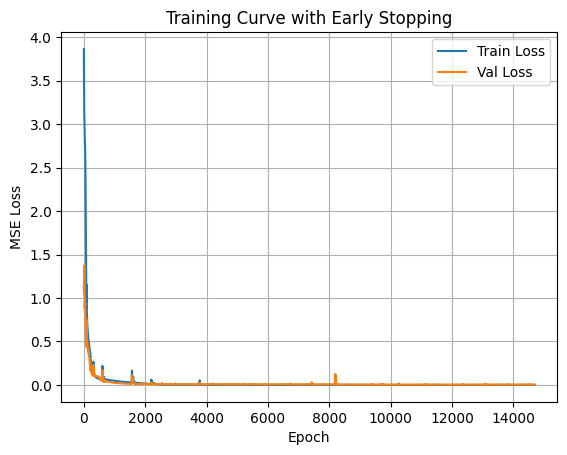

In [65]:
# Model setup
gru1_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru1_model.parameters(), lr=0.0025)

# Early stopping parameters
patience = 5000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 15000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru1_model.train()
    optimizer.zero_grad()
    y_pred_train = gru1_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru1_model.eval()
    with torch.no_grad():
        y_pred_val = gru1_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru1_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    gru1_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
# Predict on validation set
gru1_model.eval()
with torch.no_grad():
    y_pred_scaled = gru1_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru1 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru1)
mae = mean_absolute_error(y_true, y_pred_gru1)
r2 = r2_score(y_true, y_pred_gru1)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.001 cm/s
MAE: 0.011 cm/s
R² Score: 0.996


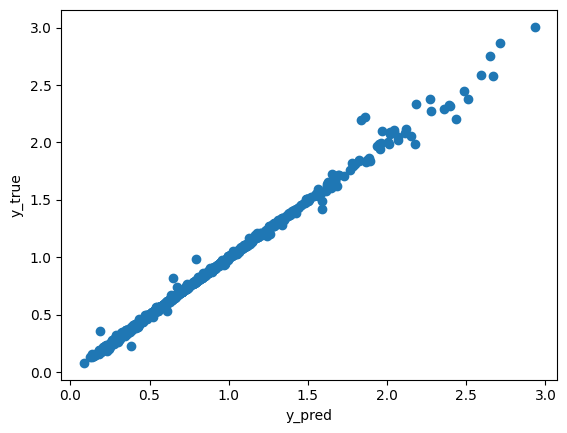

In [67]:
plt.figure()
plt.scatter(y_pred_gru1,y_true)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [95]:
gru2_model = GRUModel(input_size=1, hidden_size=11, num_layers=3)
gru2_model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()

# Early stopping setup
patience = 2000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training
epochs = 15000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru2_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 250 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    gru2_model.load_state_dict(best_model_state)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/15000 - Train Loss: 3.4811 - Val Loss: 1.2091
Epoch 250/15000 - Train Loss: 1.4832 - Val Loss: 0.4570
Epoch 500/15000 - Train Loss: 0.5385 - Val Loss: 0.3048
Epoch 750/15000 - Train Loss: 0.2611 - Val Loss: 0.1761
Epoch 1000/15000 - Train Loss: 0.1254 - Val Loss: 0.1127
Epoch 1250/15000 - Train Loss: 0.1512 - Val Loss: 0.1236
Epoch 1500/15000 - Train Loss: 0.1348 - Val Loss: 0.1447
Epoch 1750/15000 - Train Loss: 0.1187 - Val Loss: 0.1454
Epoch 2000/15000 - Train Loss: 0.1132 - Val Loss: 0.1457
Epoch 2250/15000 - Train Loss: 0.1054 - Val Loss: 0.1427
Epoch 2500/15000 - Train Loss: 0.0951 - Val Loss: 0.1355
Epoch 2750/15000 - Train Loss: 0.0870 - Val Loss: 0.1016
Epoch 3000/15000 - Train Loss: 0.0820 - Val Loss: 0.0908
Epoch 3250/15000 - Train Loss: 0.0773 - Val Loss: 0.0877
Epoch 3500/15000 - Train Loss: 0.0719 - Val Loss: 0.0854
Epoch 3750/15000 - Train Loss: 0.0684 - Val Loss: 0.0829
Epoch 4000/15000 - Train Loss: 0.0655 - Val Loss: 0.0799
Epoch 4250/15000 - Train Loss: 0.0606

KeyboardInterrupt: 

In [96]:
# Predict on validation set
gru2_model.eval()
with torch.no_grad():
    y_pred_scaled = gru2_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru2 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru2)
mae = mean_absolute_error(y_true, y_pred_gru2)
r2 = r2_score(y_true, y_pred_gru2)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.001 cm/s
MAE: 0.016 cm/s
R² Score: 0.994


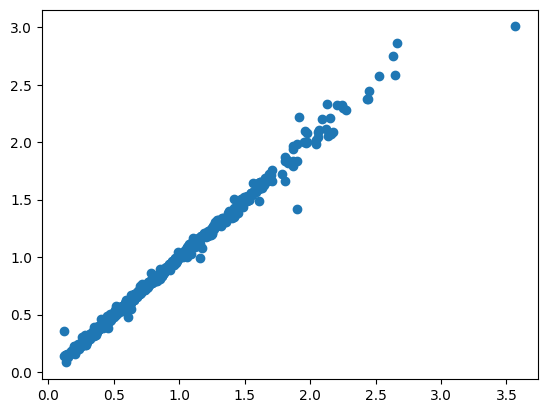

In [97]:
plt.figure()
plt.scatter(y_pred_gru2,y_true)
plt.show()

Epoch 1/50000 - Train Loss: 4.0946 - Val Loss: 1.2142
Epoch 500/50000 - Train Loss: 3.3596 - Val Loss: 1.3577
Epoch 1000/50000 - Train Loss: 2.8308 - Val Loss: 1.0009
Epoch 1500/50000 - Train Loss: 2.6297 - Val Loss: 0.9566
Epoch 2000/50000 - Train Loss: 2.4362 - Val Loss: 0.9395
Epoch 2500/50000 - Train Loss: 2.0912 - Val Loss: 0.8788
Epoch 3000/50000 - Train Loss: 1.1510 - Val Loss: 0.6715
Epoch 3500/50000 - Train Loss: 0.5789 - Val Loss: 0.3073
Epoch 4000/50000 - Train Loss: 0.4648 - Val Loss: 0.2210
Epoch 4500/50000 - Train Loss: 0.5521 - Val Loss: 0.3524
Epoch 5000/50000 - Train Loss: 0.4221 - Val Loss: 0.3224
Epoch 5500/50000 - Train Loss: 0.3184 - Val Loss: 0.2747
Epoch 6000/50000 - Train Loss: 0.2027 - Val Loss: 0.2234
Epoch 6500/50000 - Train Loss: 0.1502 - Val Loss: 0.1880
Epoch 7000/50000 - Train Loss: 0.1223 - Val Loss: 0.1568
Epoch 7500/50000 - Train Loss: 0.1050 - Val Loss: 0.1378
Epoch 8000/50000 - Train Loss: 0.0924 - Val Loss: 0.1266
Epoch 8500/50000 - Train Loss: 0.08

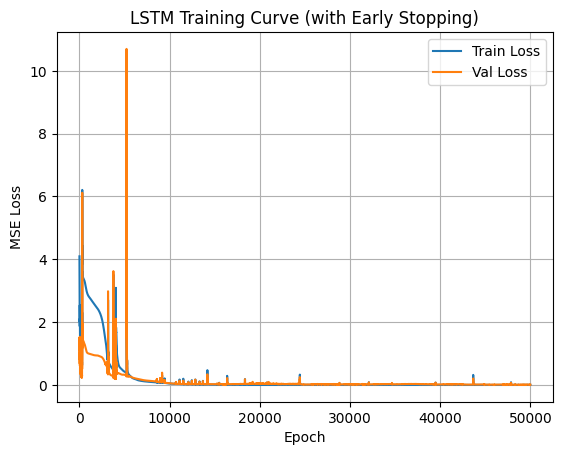

In [107]:
lstm_model = LSTMModel(input_size=1, hidden_size=18, num_layers=2)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.008)

# Early stopping setup
patience = 20000
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 50000
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = {k: v.clone() for k, v in lstm_model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 500 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
lstm_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [108]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.001 cm/s
MAE: 0.016 cm/s
R² Score: 0.996


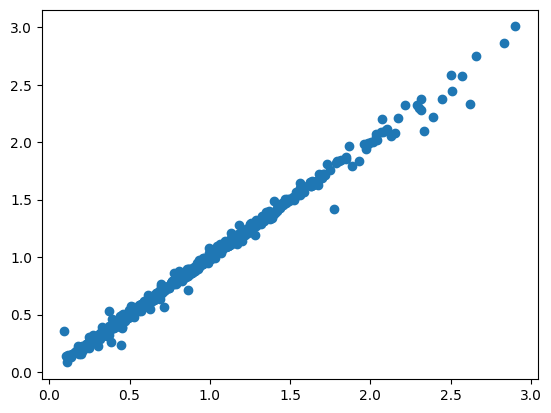

In [109]:
plt.figure()
plt.scatter(y_pred_lstm,y_true)
plt.show()

In [111]:

torch.save(gru1_model.state_dict(), path_to_output+"/models/gru22-5_2-20%3_is1_ns20_nl2_lr0.0025_ep14695_r20.996")
torch.save(gru2_model.state_dict(), path_to_output+"/models/gru22-5_2-20%3_is1_ns11_nl3_lr0.0005_ep10000_r20.994")
torch.save(lstm_model.state_dict(), path_to_output+"/models/lstm22-5_2-20%3_is1_ns18_nl2_lr0.008_ep50000_r20.996")